We start with a simple ODE:

$$\dfrac{dx}{dt}=\lambda x, x(t=t_0)=x_0$$

This problem can be formulated as a machine learning problem where the training examples are

$$(t_i, \lambda x_i), i \in \{1, 2, ..., N\}$$

and the loss function is

$$\mathcal{L}(\text{NN})=(\dfrac{dx}{dt}-\lambda x)^2$$

where NN is the transformation learned by a neural network. We can enforce the initial condition $x(t=t_0)=x_0$ by setting

$$x = x_0 + (t-t_0)\text{NN}(t)$$

at the output layer of the network.

In [1]:
import torch
import torch.nn            as nn
import torch.optim         as optim
import torch.autograd      as autograd

import numpy as np
import matplotlib.pyplot   as plt
%matplotlib inline

In [2]:
class FCNN(nn.Module):
    """
    A fully connected neural network with one hidden layer. It is hard coded to solve the ODE dx/dt = lambda*x
    """
    def __init__(self, hidden_units, initial_conidtion, lambda_, activation_fn):
        """
        :param initial_conidtion: a tuple (x_0, t_0) specifying the initial condition of the ODE: x(t_0) = x_0
        :param lambda_: the value of lambda in dx/dt = lambda*x
        :param activation_fn: the activation fucntion used at the hidden layer and outpur layer
        """
        super(FCNN, self).__init__()
        self.t_0, self.x_0 = initial_conidtion
        self.lambda_ = lambda_
        self.activation_fn = activation_fn
        self.fc1 = nn.Linear(1, hidden_units)
        self.fc2 = nn.Linear(hidden_units, 1)

    def forward(self, t):
        x = self.activation_fn(self.fc1(t))
        x = self.activation_fn(self.fc2(x))
        x = self.x_0 + (t-self.t_0)*x # enforcing the initial condition
        return x

In [3]:
def get_examples(size, t_min=0.0, t_max=1.0, equally_spaced=False):
    examples = torch.linspace(t_min, t_max, size) if equally_spaced else torch.rand(size)*(t_max-t_min) + t_min
    examples.requires_grad = True
    return examples

In [4]:
def train(fcnn, examples, optimizer, criterion, n_epochs, batch_size):
    """
    Train a fully connected neural network to solve an ODE. It is hard coded to solve the ODE dx/dt = lambda*x.
    The training is done using mini-batches.
    :param fcnn: a fully connected neural network
    :param examples: the set of ts to train the neural network on
    :param optimizer: a optimizer from pytorch.optim
    :param criterion: a loss function from pytorch.nn
    :param n_epochs: the number of passes through the training set
    :param batch_size: the size of the minibatch
    """
    n_examples = len(examples)
    if n_examples%batch_size != 0:
        # I know this is stupid, I'll fix this later
        raise RuntimeError('Please choose a batch_size such that it is a factor of the size of the training set.')
    n_batches = n_examples//batch_size
    
    loss_history = torch.zeros(n_epochs)
    
    for epoch in range(n_epochs):
        loss_epoch = 0.0
        perm = torch.randperm(n_examples)
        t_in_batches = examples[perm].reshape((n_batches, batch_size, 1))
        for t_in in t_in_batches:
            optimizer.zero_grad()

            x_out = fcnn(t_in)
            # the right hand side of the ODE, it should be extracted out of this function for generalization
            dxdt_true = x_out * fcnn.lambda_ 
            dxdt      = autograd.grad(x_out, t_in, create_graph=True, 
                                      grad_outputs=torch.ones_like(dxdt_true))[0]
            loss = criterion(dxdt, dxdt_true)
            loss_epoch += loss.item()
            loss.backward(retain_graph=True)
#             loss.backward()

            
            optimizer.step()
        loss_history[epoch] = loss_epoch/n_batches
    
    return loss_history.detach().numpy()

In [5]:
lambda_       = 1.0
t_0,   x_0    = 0.0, 1.0
t_min, t_max  = 0.0, 1.0
activation_fn = torch.relu

# solve for dx/dt = x, x(t=0) = 1
fcnn = FCNN(hidden_units=16, initial_conidtion=(t_0, x_0), lambda_=lambda_, activation_fn=activation_fn)
# generate training examples in the range (t_min, t_max)
ts_train = get_examples(256, t_min, t_max, equally_spaced=True)
# pytorch's SGD is actually a gradient descent optimizer, if we update with one example at a time then it's SGD,
# if we update with a mini-batch at a time them it's mini-batch gradient descent
optimizer = optim.SGD(fcnn.parameters(), lr=0.01)
criterion = nn.MSELoss()

loss_history = train(fcnn, ts_train, optimizer=optimizer, criterion=criterion,\
                     n_epochs=100, batch_size=16)

/anaconda3/envs/nde/lib/python3.6/site-packages/matplotlib/axes/_base.py:3507: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  self.set_ylim(upper, lower, auto=None)


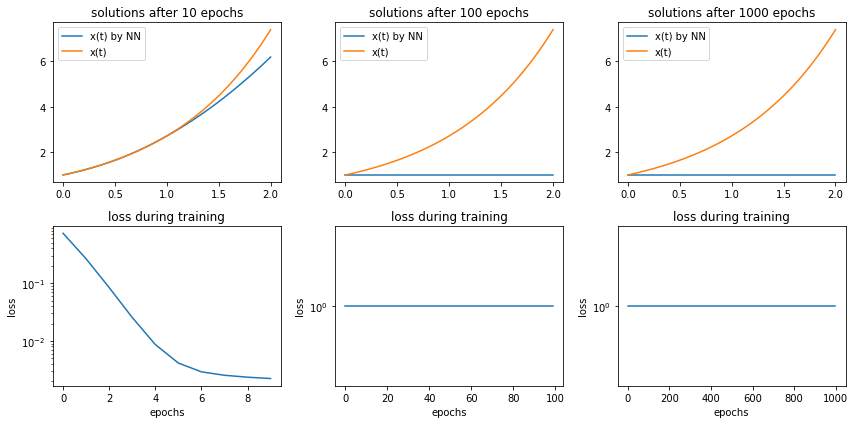

In [6]:
lambda_       = 1.0
t_0,   x_0    = 0.0, 1.0
t_min, t_max  = 0.0, 1.0
activation_fn = torch.relu
batch_size = 16

ts_train  = get_examples(256, t_min, t_max, equally_spaced=True)
optimizer_class = optim.SGD
criterion = nn.MSELoss()

plot_t_min, plot_t_max = t_min, t_max+1
plt.figure(figsize=(12, 6))
for i, n_epochs in enumerate([10, 100, 1000]):
    
    fcnn = FCNN(hidden_units=16, initial_conidtion=(t_0, x_0), lambda_=lambda_, activation_fn=activation_fn)
    
    optimizer = optimizer_class(fcnn.parameters(), lr=0.01)
    loss_history = train(fcnn, ts_train, optimizer=optimizer, criterion=criterion,\
                         n_epochs=n_epochs, batch_size=batch_size)
    
    ts = np.linspace(plot_t_min, plot_t_max, 100)
    xs = fcnn( torch.linspace(plot_t_min, plot_t_max, 100).reshape((-1, 1, 1)) )\
         .detach().numpy().flatten()

    plt.subplot(2, 3, i+1)
    plt.plot(ts, xs,                     label='x(t) by NN')
    plt.plot(ts, x_0*np.exp(lambda_*ts), label='x(t)')
    plt.legend()
    plt.title(f'solutions after {n_epochs} epochs')

    plt.subplot(2, 3, i+4)
    plt.plot(loss_history)
    plt.title('loss during training')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.yscale('log')

plt.tight_layout()
plt.show()

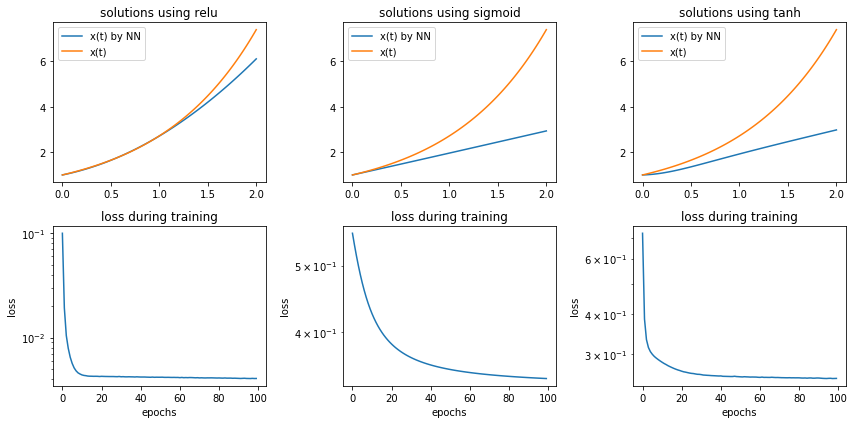

In [7]:
lambda_       = 1.0
t_0,   x_0    = 0.0, 1.0
t_min, t_max  = 0.0, 1.0
n_epochs   = 100
batch_size = 16

ts_train = get_examples(256, t_min, t_max, equally_spaced=True)
optimizer_class = optim.SGD
criterion = nn.MSELoss()

plot_t_min, plot_t_max = t_min, t_max+1
plt.figure(figsize=(12, 6))
for i, (name, activation_fn) in enumerate(zip( ['relu', 'sigmoid', 'tanh'], [torch.relu, torch.sigmoid, torch.tanh] )):
    
    fcnn = FCNN(hidden_units=16, initial_conidtion=(t_0, x_0), lambda_=lambda_, activation_fn=activation_fn)
    
    optimizer = optimizer_class(fcnn.parameters(), lr=0.01)
    loss_history = train(fcnn, ts_train, optimizer=optimizer, criterion=criterion,\
                         n_epochs=n_epochs, batch_size=batch_size)
    
    ts = np.linspace(plot_t_min, plot_t_max, 100)
    xs = fcnn( torch.linspace(plot_t_min, plot_t_max, 100).reshape((-1, 1, 1)) )\
         .detach().numpy().flatten()

    plt.subplot(2, 3, i+1)
    plt.plot(ts, xs,                     label='x(t) by NN')
    plt.plot(ts, x_0*np.exp(lambda_*ts), label='x(t)')
    plt.legend()
    plt.title(f'solutions using {name}')

    plt.subplot(2, 3, i+4)
    plt.plot(loss_history)
    plt.title('loss during training')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.yscale('log')

plt.tight_layout()
plt.show()

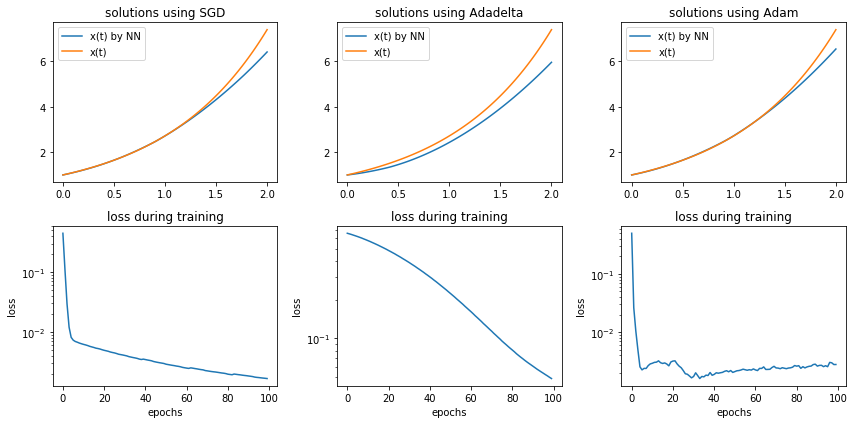

In [8]:
lambda_       = 1.0
t_0,   x_0    = 0.0, 1.0
t_min, t_max  = 0.0, 1.0
activation_fn = torch.relu
n_epochs   = 100
batch_size = 16

ts_train = get_examples(256, t_min, t_max, equally_spaced=True)
criterion = nn.MSELoss()

plot_t_min, plot_t_max = t_min, t_max+1
plt.figure(figsize=(12, 6))
for i, (name, optimizer_class) in enumerate(zip( ['SGD', 'Adadelta', 'Adam'], 
                                           [optim.SGD, optim.Adadelta, optim.Adam] )):
    
    fcnn = FCNN(hidden_units=16, initial_conidtion=(t_0, x_0), lambda_=lambda_, activation_fn=activation_fn)
    
    optimizer = optimizer_class(fcnn.parameters(), lr=0.01)
    loss_history = train(fcnn, ts_train, optimizer=optimizer, criterion=criterion,\
                         n_epochs=n_epochs, batch_size=batch_size)
    
    ts = np.linspace(plot_t_min, plot_t_max, 100)
    xs = fcnn( torch.linspace(plot_t_min, plot_t_max, 100).reshape((-1, 1, 1)) )\
         .detach().numpy().flatten()

    plt.subplot(2, 3, i+1)
    plt.plot(ts, xs,                     label='x(t) by NN')
    plt.plot(ts, x_0*np.exp(lambda_*ts), label='x(t)')
    plt.legend()
    plt.title(f'solutions using {name}')

    plt.subplot(2, 3, i+4)
    plt.plot(loss_history)
    plt.title('loss during training')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.yscale('log')

plt.tight_layout()
plt.show()

The code is still broken:
* Activation function: relu sometimes gives a flat line, sigmoid seems to converge slowly (deminishing gradient?)
* Using t_in=linspace(0, 3, 100) or linspace(-1, 1, 100) gives flat line (something wrong with weight initialization?)